In [107]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [108]:
bfstats = [filename for filename in os.listdir() if 'bfvstats' in filename][0]

In [109]:
df = pd.read_csv(bfstats, index_col=0)

In [110]:
df.head()

,player_id,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,deaths_percentile,...,Tanker_shotsFired_value,Tanker_shotsFired_percentile,Tanker_shotsHit_value,Tanker_shotsHit_percentile,Tanker_shotsAccuracy_value,Tanker_shotsAccuracy_percentile,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn/themadbat2,psn,378.992866,71.0,2.620838,93.0,510901,99.9,194938,NaN,...,0,NaN,0,NaN,0.0,NaN,1774991,94.0,813.469753,64.0
1,psn/lhluslhlkuslhl,psn,549.270059,96.6,5.598978,99.0,657208,99.9,117380,NaN,...,0,NaN,0,NaN,0.0,NaN,159756,69.0,420.410526,24.0
2,psn/jawasandcrawler,psn,252.318010,28.0,1.751341,79.0,420884,99.9,240321,NaN,...,0,NaN,0,NaN,0.0,NaN,84699,58.0,1693.980000,81.0
3,origin/z1nyorita,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,NaN,...,0,NaN,0,NaN,0.0,NaN,9943381,99.5,748.410432,61.0
4,psn/arjen10_ooorwhat,psn,316.079128,50.0,2.542558,93.0,442278,99.9,173950,NaN,...,0,NaN,0,NaN,0.0,NaN,35013,41.0,2059.588235,84.0


There are many features. Given I simply dumped data from an API into a csv file, and I suspect at least some features only took one unique value, I check to see if that is the case. Features taking only one value, whether NaN values or other values, are useless when applying machine learning methods, since they do not distinguish any sample from any other sample. This does not make such features useless per se (ex. suppose you learned everyone on Earth's favorite color was red; this would be very interesting if not useful for distinguishing between people).

In [111]:
null_features = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        null_features.append(col)
num_null_features = len(null_features)
print(f'There are {num_null_features} features with only one unique value')

There are 104 features with only one unique value


This is a lot of features. I expect many of them are percentiles, as eyeballing the JSON, it appeared not all of these features actually took non-None values. I check this assumption below.

In [112]:
null_percentile_features = []
null_other_features = []
for feature in null_features:
    if 'percentile' in feature:
        null_percentile_features.append(feature)
    else:
        null_other_features.append(feature)
num_percentile_null_features = len(null_percentile_features)
print(f'Of features taking only one unique value, {num_percentile_null_features} are percentiles.')
print(f'The other features taking only one unique value are below:')
null_other_features

Of features taking only one unique value, 93 are percentiles.
The other features taking only one unique value are below:


['rankScore_value',
 'Pilot_deaths_value',
 'Pilot_kdRatio_value',
 'Pilot_shotsFired_value',
 'Pilot_shotsHit_value',
 'Pilot_shotsAccuracy_value',
 'Tanker_deaths_value',
 'Tanker_kdRatio_value',
 'Tanker_shotsFired_value',
 'Tanker_shotsHit_value',
 'Tanker_shotsAccuracy_value']

Below I check to see if these features have unique values that are non-NaN and greater than zero, a value of zero being unreasonable for all of thousands of players.

In [113]:
for feat in null_other_features + null_percentile_features:
    non_null_count = 0
    if  df[feat].unique()[0] != 0 and (not df[feat].isna().all()):
        print(f'{feat} takes a non-NaN value')
        non_null_count += 1
if non_null_count == 0:
    print('All of the scores take either NaN values or 0 as their only value.')

All of the scores take either NaN values or 0 as their only value.


We can discard the features discussed above as useless. While taking only a single value does not make a feature useless to any sort of analysis, the values these features take must mean that the features simply refer to metrics that were not stored. This is moreso obvious for anything taking a NaN value, but it simply could not be the case that every player on the leaderboard has an accuracy of zero with tanks - you could undoubtedly look up some of these players on Youtube to confirm that.

In [114]:
df.drop(null_other_features + null_percentile_features, axis=1, inplace=True)

In [115]:
df.head()

,player_id,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,...,Support_score_percentile,Support_scorePerMinute_value,Support_scorePerMinute_percentile,Tanker_kills_value,Tanker_killsPerMinute_value,Tanker_timePlayed_value,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn/themadbat2,psn,378.992866,71.0,2.620838,93.0,510901,99.9,194938,58929960,...,99.2,288.500482,40.0,4388,2.010999,130965,1774991,94.0,813.469753,64.0
1,psn/lhluslhlkuslhl,psn,549.270059,96.6,5.598978,99.0,657208,99.9,117380,71931790,...,99.9,564.879871,96.3,415,1.092105,22805,159756,69.0,420.410526,24.0
2,psn/jawasandcrawler,psn,252.318010,28.0,1.751341,79.0,420884,99.9,240321,51059314,...,99.8,241.398932,25.0,170,3.400000,3025,84699,58.0,1693.980000,81.0
3,origin/z1nyorita,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,107543331,...,99.9,687.984176,98.6,36641,2.757865,797160,9943381,99.5,748.410432,61.0
4,psn/arjen10_ooorwhat,psn,316.079128,50.0,2.542558,93.0,442278,99.9,173950,50978898,...,99.7,330.270351,54.0,22,1.294118,1040,35013,41.0,2059.588235,84.0


# Feature Engineering

## Convert Time Features
The time played features are given in seconds. I would prefer to have these in hours to make them easier to read.

In [116]:
for feature in df.columns:
    if 'timeplayed' in feature.lower():
        df[feature] /= 3600

## Scaling Features by Time Played
A number of features here are presented in raw values like damage_value, which gives the amount of damage a player has done while playing the game. This value, however, will be influenced by the amount of time a player has played the game. A more interpretable measure would be the amount of damage a player has done per unit of time played. To be consistent with features already in the dataset, I will scale time independent features on a per minute basis. I will not scale features that already have some per minute equivalent, like kills per minute or shot accuracy.

Note that this should not remove time dependence entirely. The average player who has only played 5 hours is likely to have fewer kills per minute than someone with 500 hours played because they have less familiarity with the game, for example.

In [117]:
features_to_scale = ['deaths_value', 'assists_value', 'assistsAsKills_value', 'dogtagsTaken_value', 'avengerKills_value', 'saviorKills_value', 'headshots_value', \
    'suppressionAssists_value', 'heals_value', 'revives_value', 'revivesRecieved_value', 'resupplies_value', 'repairs_value', 'aceSquad_value', 'squadSpawns_value', 'squadWipes_value', 'ordersCompleted_value',\
        'scoreMedic_value', 'scoreAssault_value', 'scoreSupport_value', 'scoreRecon_value', 'scoreAir_value', 'scoreLand_value', 'scoreTanks_value', 'scoreTransports_value', 'scoreRound_value',\
            'scoreGeneral_value', 'scoreCombat_value', 'scoreDefensive_value', 'scoreObjective_value', 'scoreBonus_value', 'scoreSquad_value', 'scoreAward_value']

for feature in features_to_scale:
    df[f'{feature}_PerMinute'] = df[feature]/(df['timePlayed_value'] * 60)

I then drop the untransformed features.

In [118]:
#df.drop(features_to_scale, axis=1, inplace=True)

# Exploratory Data Analysis
There are enough features that plotting all of their distributions at once is a bit confusing. So first, I break the features into categories, one for each class, vehicle and a catch all category for the rest. Then I plot each category separately.

In [119]:
medic_features = [ ]
assault_features = []
support_features = []
recon_features = []
ground_vehicle_features = []
plane_features = []
general_features = []

for feature in df.columns:
    if 'medic' in feature.lower():
        medic_features.append(feature)
    elif 'assault' in feature.lower():
        assault_features.append(feature)
    elif 'support' in feature.lower():
        support_features.append(feature)
    elif 'recon' in feature.lower():
        recon_features.append(feature)
    elif 'tank' in feature.lower() or 'transport' in feature.lower():
        ground_vehicle_features.append(feature)
    elif 'air' in feature.lower() or 'plane' in feature.lower() or 'pilot' in feature.lower():
        plane_features.append(feature)
    else:
        general_features.append(feature)


## General Features

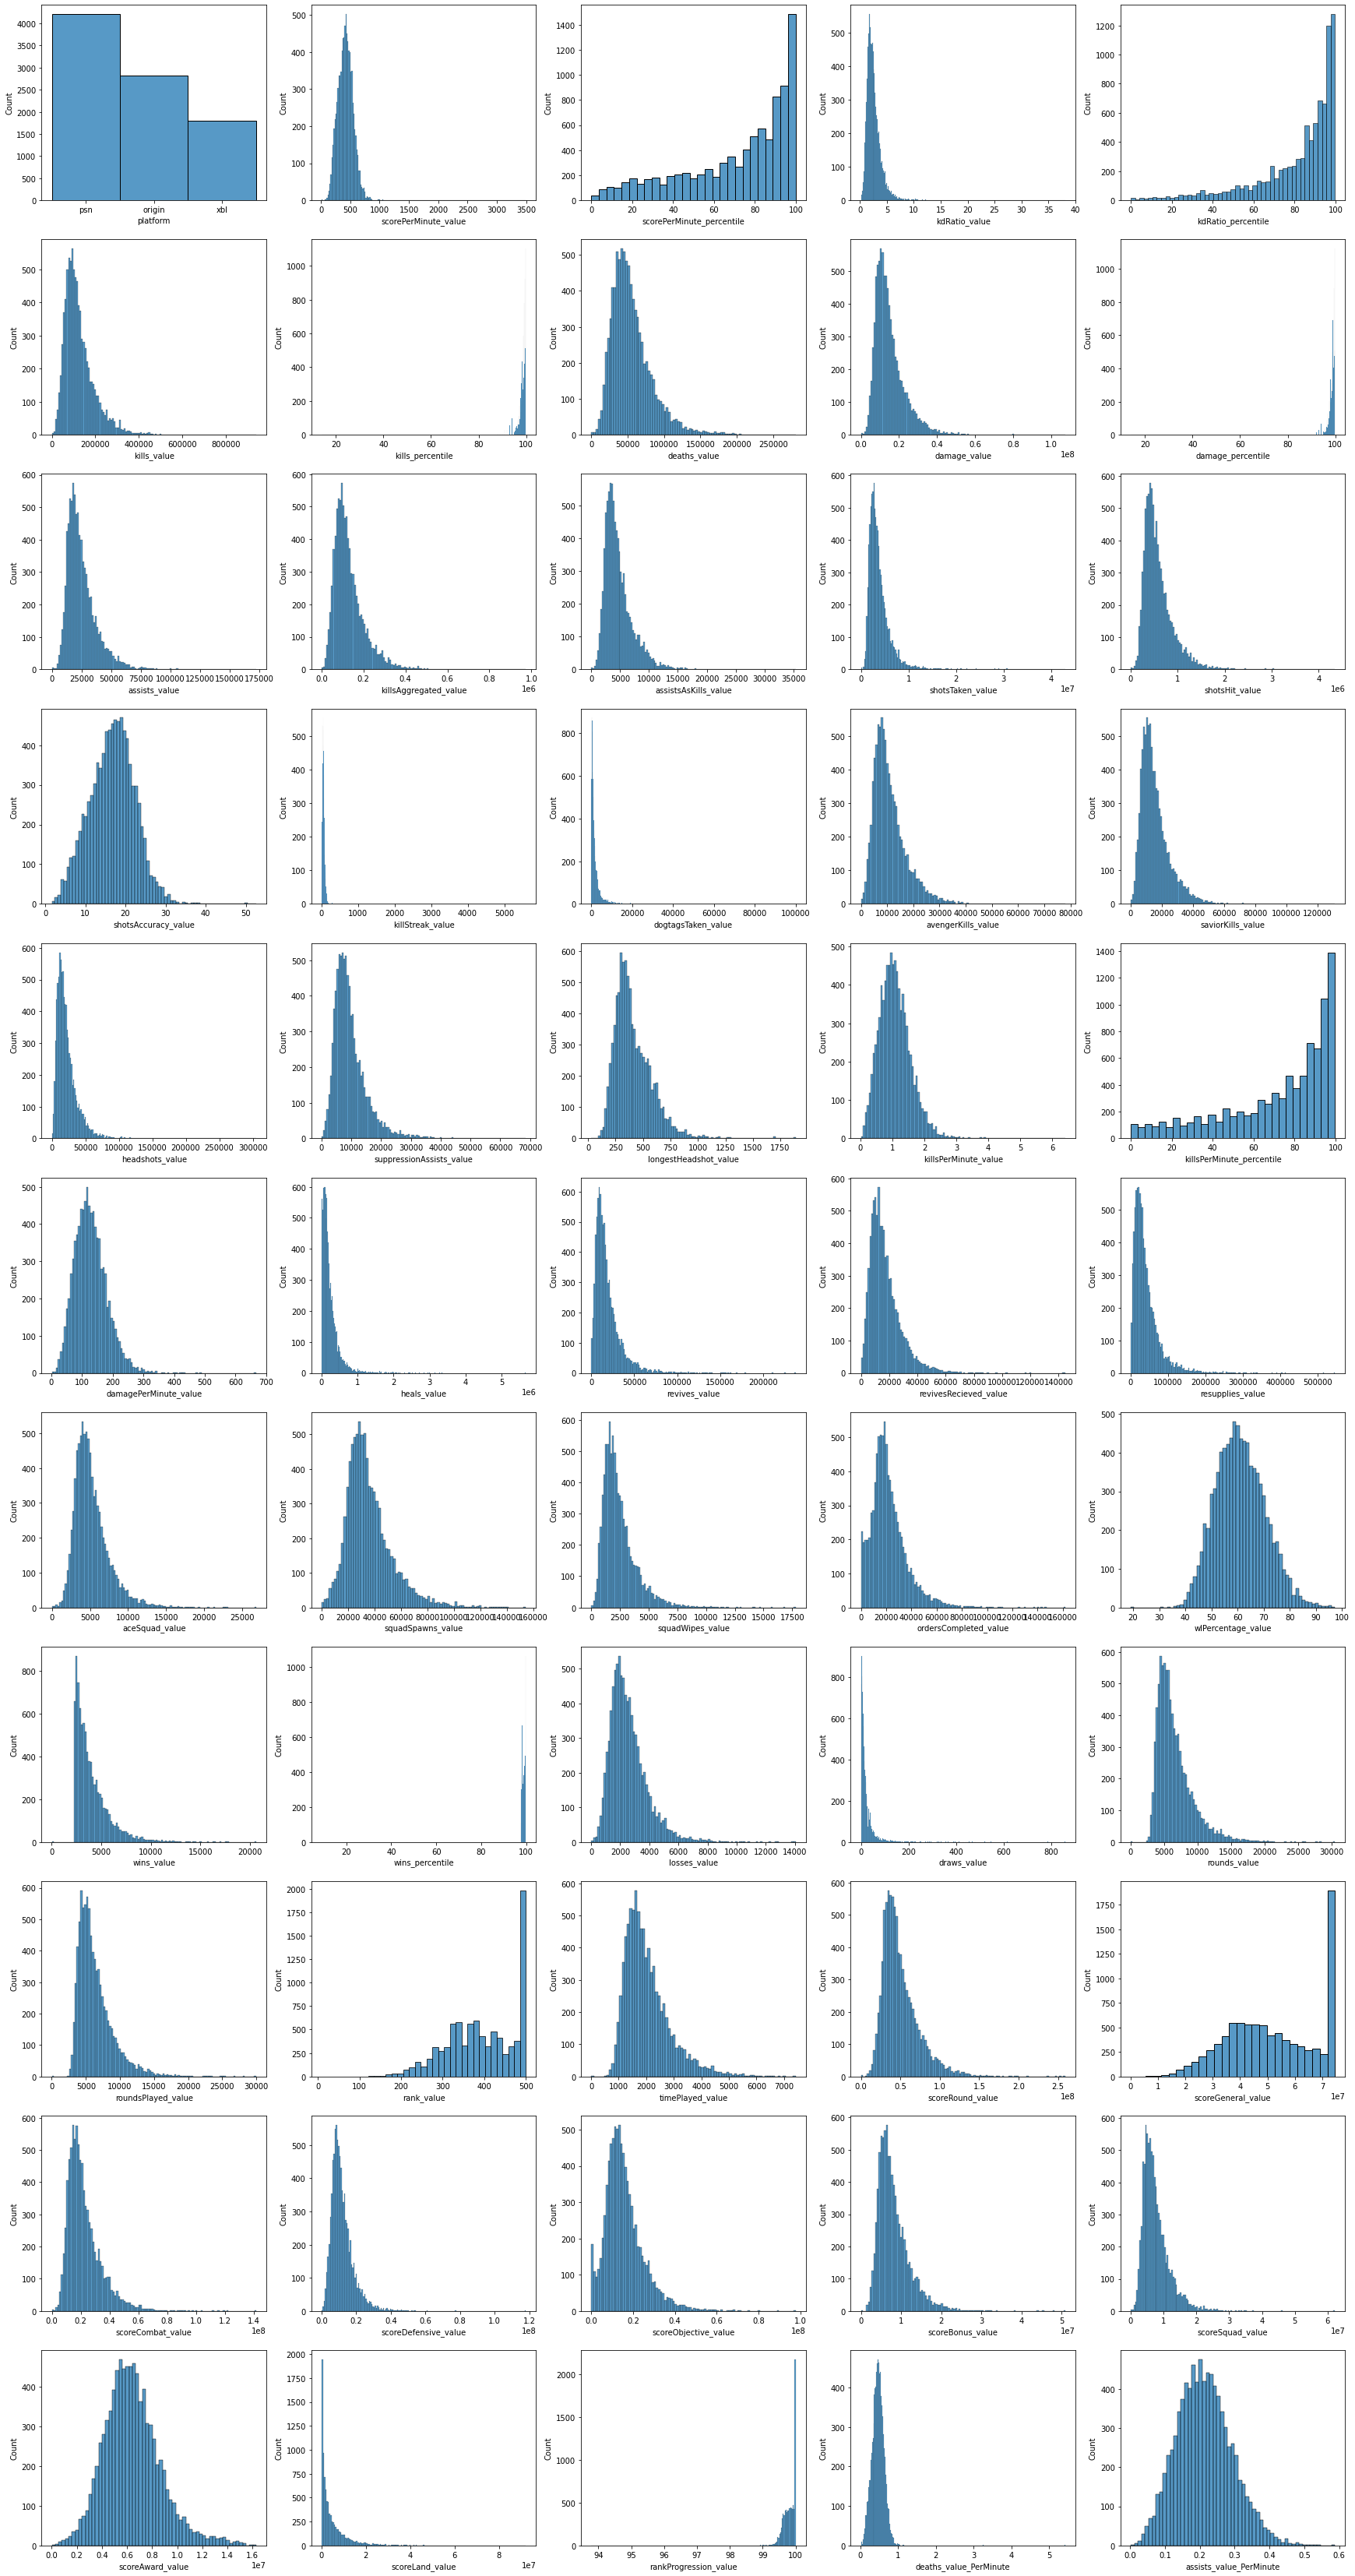

In [120]:
fig, axes = plt.subplots(11, 5, figsize=(30, 60))
for ax, feat in zip(np.ravel(axes), general_features[1:]):
    sns.histplot(data=df, x=feat, ax=ax)

## Medic Features
Note for the medic and all other classes, we have score features scaled by two different time features. Features named with the form like "Medic_scorePerMinute_value" is the score for the medic scaled by time spent playing the class. Features named with the form "scoreMedic_value_PerMinute" are scaled by total time spent playing the game.

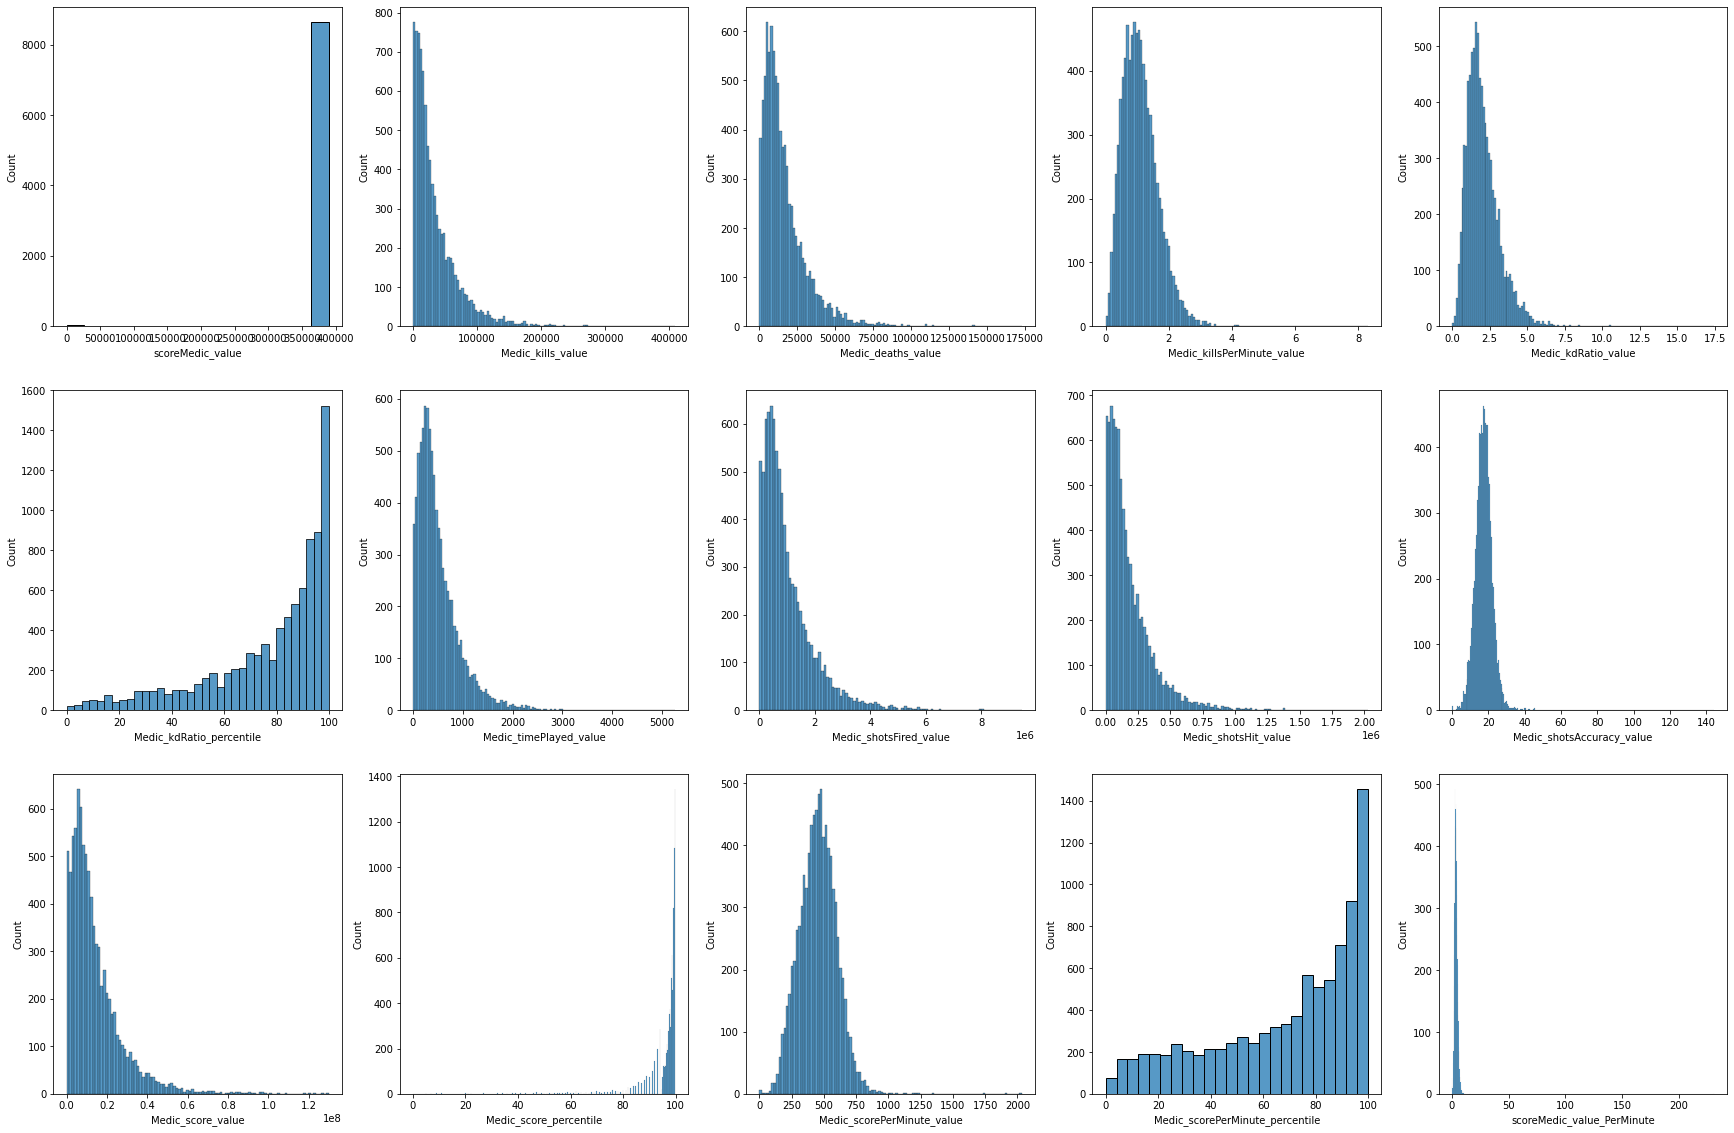

In [121]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), medic_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Assault Features

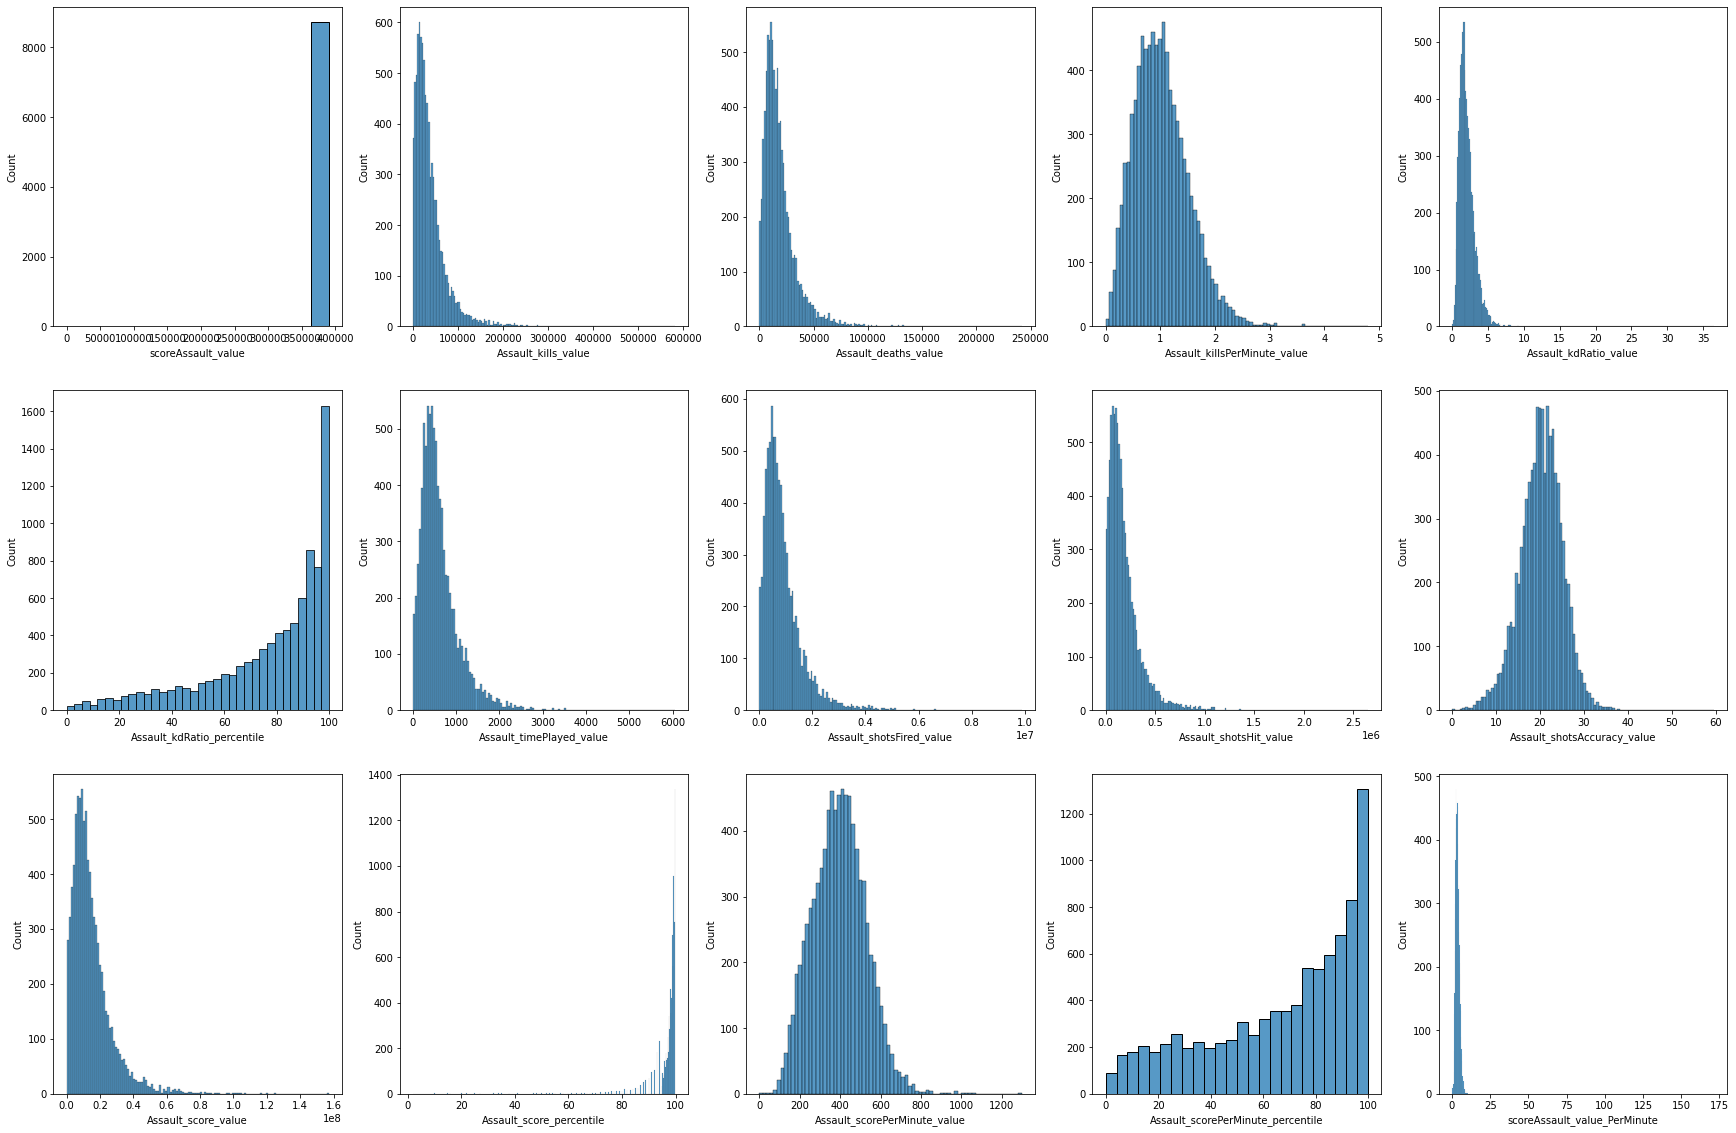

In [122]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), assault_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Support Features

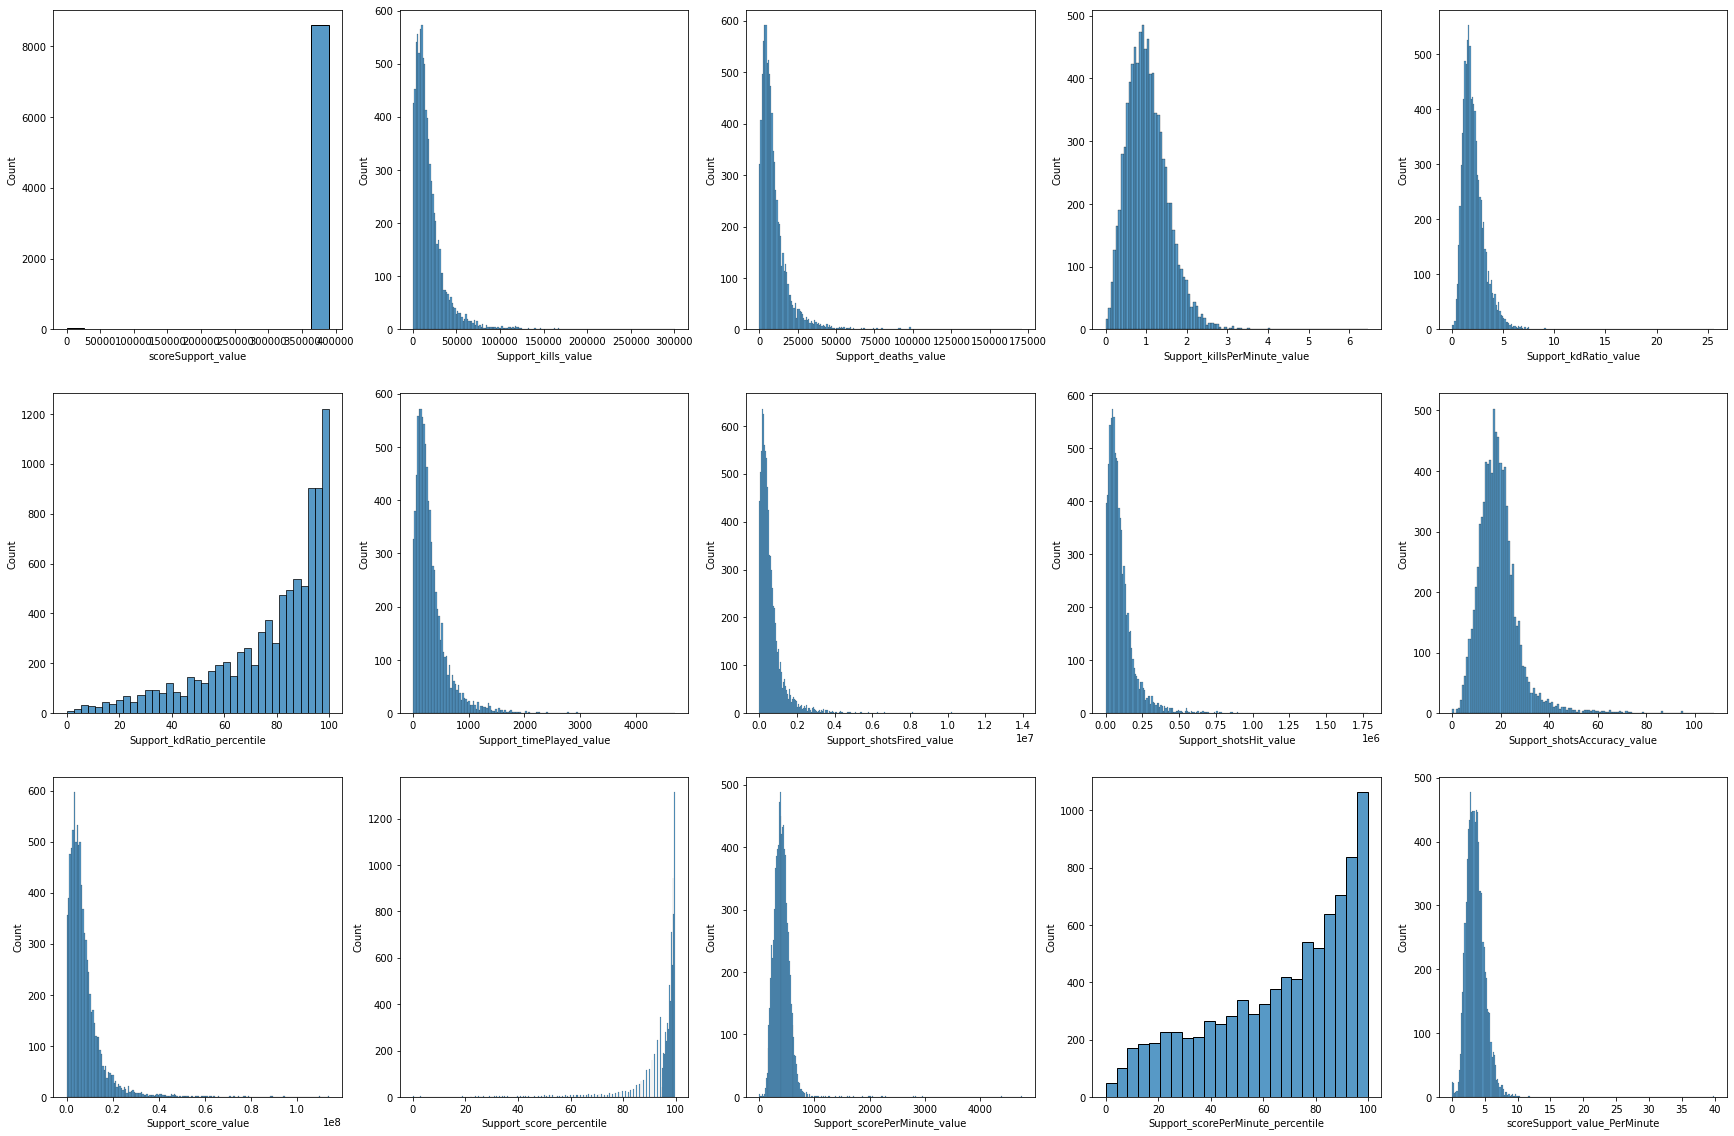

In [123]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), support_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Recon Features

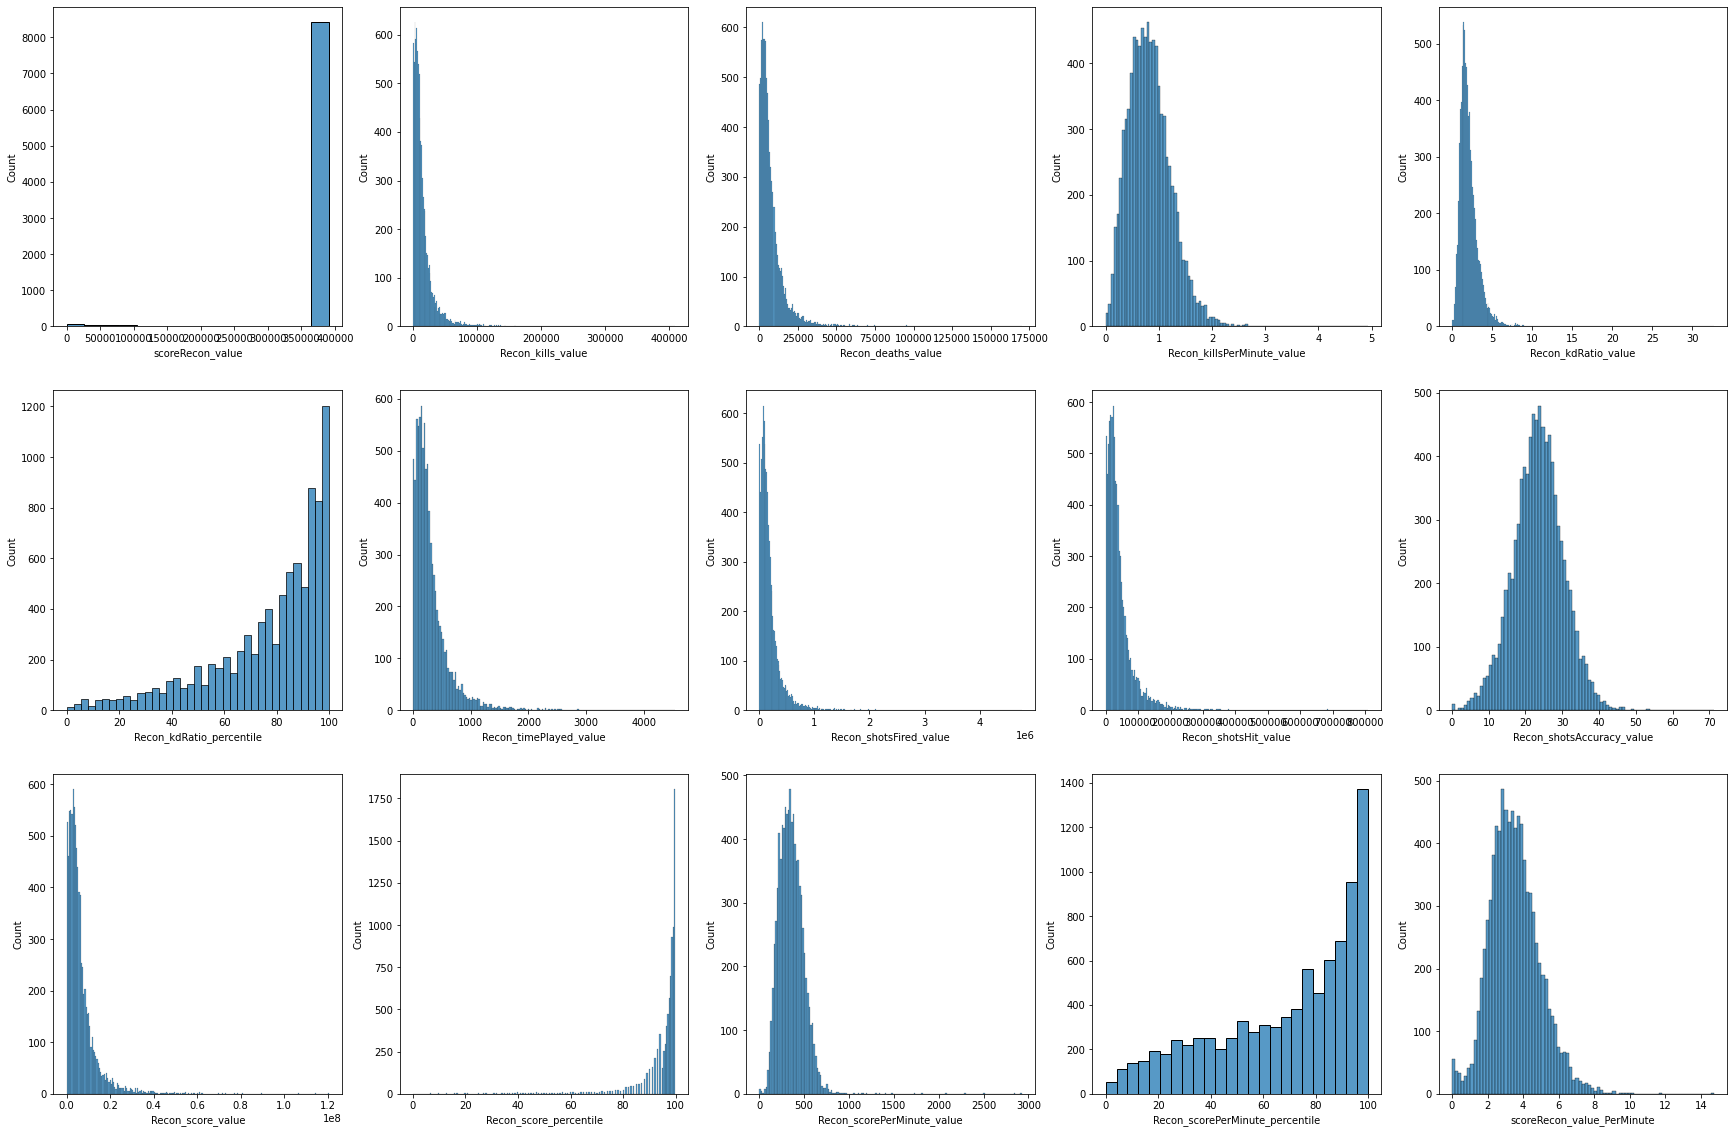

In [124]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), recon_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Ground Vehicle Features

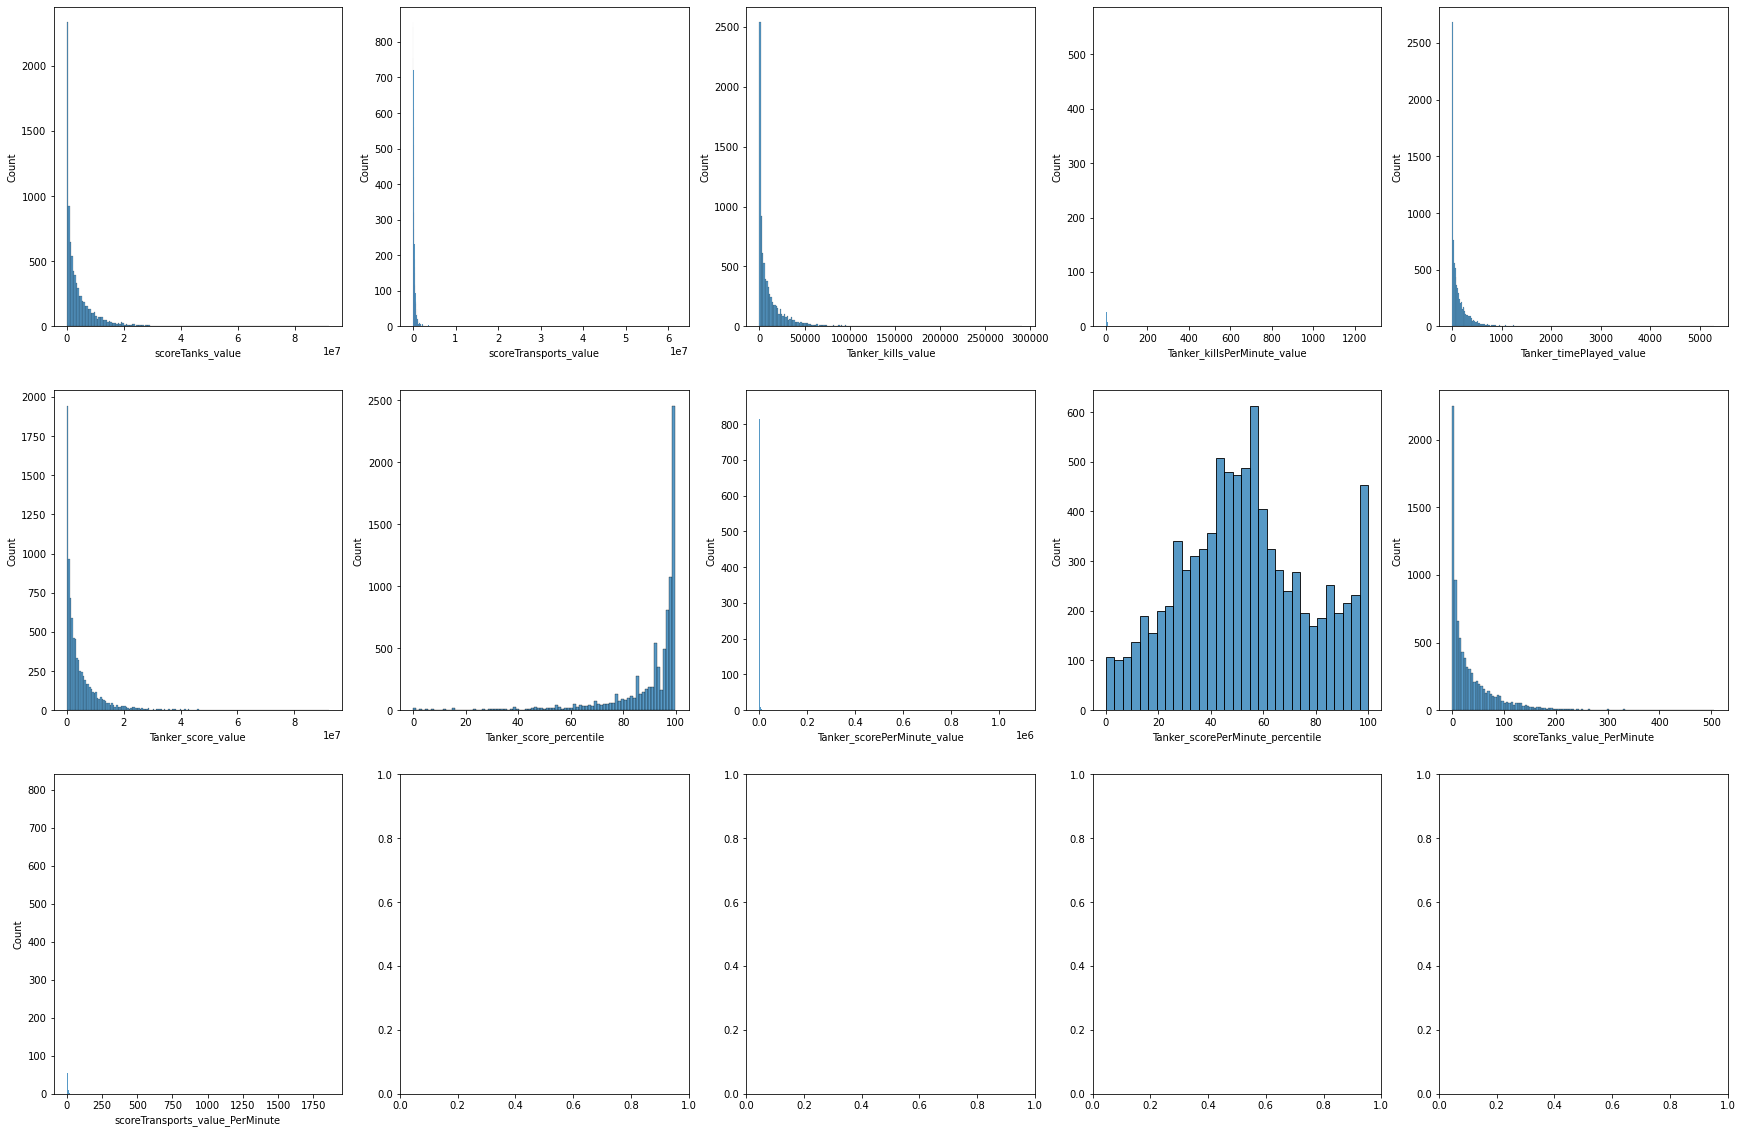

In [125]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), ground_vehicle_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Plane Features

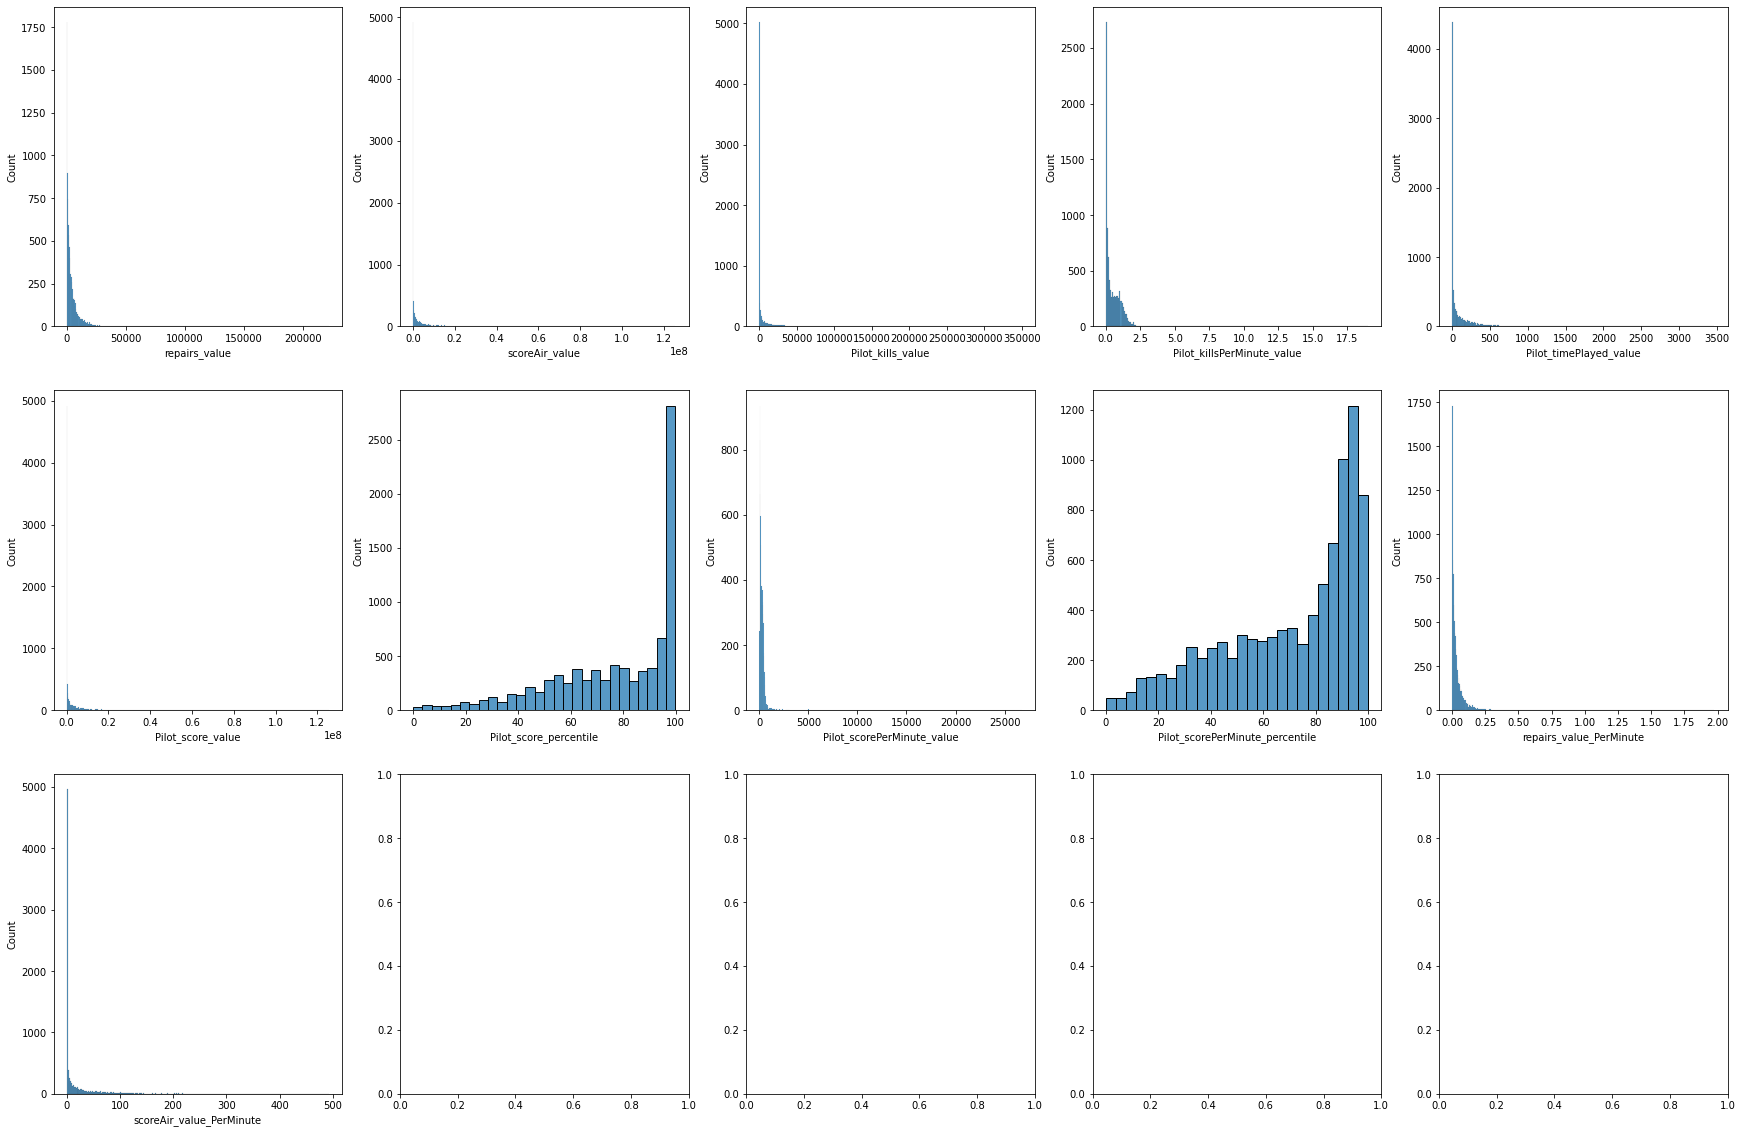

In [126]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), plane_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Outliers
The game has a known problem with cheaters, for example, people who use aimbots. I would prefer to remove these players from the dataset, as they are not representative of average players skills. I examine whether such players are in the dataset using basic statistical methods.

One thing to note here is that raw values are going to be poor for detecting outliers by themselves. If I am terrible at the game but play 6 hours a day for years, I will likely have more kills than an excellent player who only plays 2 hours per week. However, they will likely have more kills per minute or kill death ratios. So when looking for outliers, I use features adjusted for time when possible.

Outlier detection will also be important for clustering. To cluster, I will be using KMeans. This algorithm computes cluster centers as the mean value of points in a cluster. The mean is sensetive to outliers (ex. consider the means of [1,2,3,4,5] and [1,2,3,1000,5]), thus KMeans will be sensitive to outliers. This of course does not mean that we can remove samples with a large value in a feature simply because the value is large.

## Medic and Assault Score per Minute

In [127]:
high_medic_support_score = df[(df['scoreAssault_value_PerMinute'] > 50) | (df['scoreMedic_value_PerMinute'] > 50)]
high_medic_support_score[['Medic_timePlayed_value', 'Assault_timePlayed_value', 'scoreAssault_value_PerMinute', 'scoreMedic_value_PerMinute']]

,Medic_timePlayed_value,Assault_timePlayed_value,scoreAssault_value_PerMinute,scoreMedic_value_PerMinute
4422,0.327778,3.937500,171.648000,15.586909
4866,23.408333,4.279167,154.699388,231.088288


That value of score per minute is implausible and made even more so by the fact that it has only been achieved by 2 players with low playtimes in the classes for which their score per minute is high. Those samples are removed.

In [128]:
df = df[(df['scoreAssault_value_PerMinute'] < 50) & (df['scoreMedic_value_PerMinute'] < 50)]

### Medic and Support Accuracy
Some players have accuracy values with the medic and support class over 100, which should be impossible. These players are examined then removed.

In [129]:
df[(df['Support_shotsAccuracy_value'] >= 100)  | (df['Medic_shotsAccuracy_value'] >= 100)]

,player_id,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,...,scoreTanks_value_PerMinute,scoreTransports_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
1111,origin/l3lackspaghetti,origin,569.970863,97.4,3.668982,97.5,248746,99.8,67797,26722402,...,0.553427,0.532539,569.967861,523.218360,280.261070,102.860656,189.419335,101.525663,67.736173,33.044005
2112,psn/serpaguedes,psn,556.598300,96.9,3.872084,97.8,261629,99.9,67568,28173244,...,179.301952,0.660470,556.596971,534.370166,281.953677,84.765942,192.912516,81.426579,55.989611,44.217070
5110,origin/szymeek87,origin,448.875556,87.0,2.041905,86.0,95359,98.7,46701,11835206,...,6.247949,1.384529,448.872219,514.194524,181.453592,103.375217,165.102307,77.627697,70.053287,71.565526
7493,psn/sergeantuseless,psn,314.076468,50.0,2.432497,91.0,73909,98.0,30384,9219130,...,82.474583,1.804152,314.073384,404.869591,168.411294,64.113344,82.052726,45.391087,31.821340,45.694064
7633,psn/masterofsplatter,psn,199.119959,13.0,3.211902,96.5,73832,98.0,22987,9138384,...,0.013682,0.002478,199.119454,262.632344,172.838315,25.361803,0.914015,28.032005,21.190260,50.826098


This is only a few players. They are all dropped from the dataset.

In [130]:
df = df[(df['Support_shotsAccuracy_value'] < 100)  & (df['Medic_shotsAccuracy_value'] < 100)]

### Tank Score per Minute
The distribution of score per minute for tanks immediately stands out. I do not know much about vehicles in the game, but I know that 1M score per minute is essentially impossible, especially sustained over a long period of time. Additionally, it is easier to get kills with planes, but the score per minute distribution in planes is much more reasonable.

In [131]:
tank_spm = df['Tanker_scorePerMinute_value']
tank_spm.describe()

count    8.811000e+03
mean     3.442028e+03
std      2.707525e+04
min      0.000000e+00
25%      4.913863e+02
50%      6.260485e+02
75%      1.006191e+03
max      1.093652e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that most of the values are in the hundreds or low thousands, making the 1M score range value(s) look even more suspicious. To further examine them, I look only at values above the 3rd quartile.

In [132]:
num_best_tankers = len(df[tank_spm > 10_000])
print(f'Only {num_best_tankers} have a score per minute in tanks over 10,000.')
tank_spm[tank_spm > np.quantile(tank_spm, q=0.75)].describe()

Only 399 have a score per minute in tanks over 10,000.


count    2.203000e+03
mean     1.204917e+04
std      5.323570e+04
min      1.006506e+03
25%      1.464533e+03
50%      2.647417e+03
75%      6.890983e+03
max      1.093652e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that the top 25% of the top 25% players with the highest score per minute in tanks would be outstanding to maintain a score perminute of 10,000. I feel confident in treating the players above that threshold as outliers.

In [133]:
df = df[df['Tanker_scorePerMinute_value'] <= 10_000]

We can then revisualize the distribution of score per minute in tanks.

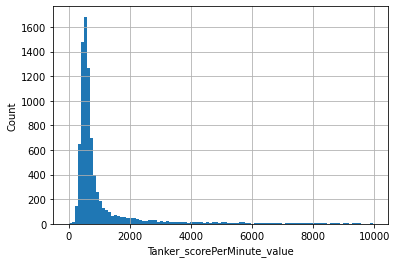

In [134]:
df['Tanker_scorePerMinute_value'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Tanker_scorePerMinute_value')
plt.show()

This looks like what we expect based on the other plots.

#### Tank Kills per Minute
The tank kills per minute distribution also looks unusual. You can think of pilot kills per minute as a rough proxy for what the distribution for tanks should look like, except tank kills per minute should probably be lower. Getting hundreds of kills per minute is impossible for human players. Removing the score per minute outliers may have removed outliers in this feature, but it is best to check.

In [135]:
df['Tanker_killsPerMinute_value'].describe()

count    8412.000000
mean        1.881448
std         2.109962
min         0.000000
25%         1.127105
50%         1.463742
75%         1.917265
max       119.183333
Name: Tanker_killsPerMinute_value, dtype: float64

We see above that there is still at least one implausible value, 119. A sustained value of 119 kills per minute with tanks is impossible. I check values over 20 to get a general idea of how much of an outlier the maximum value is.

In [136]:
df[df['Tanker_killsPerMinute_value'] > 20]['Tanker_killsPerMinute_value']

2610     22.170732
2943     22.766667
5670     22.792079
5833     22.873684
7294     21.757576
7678    119.183333
Name: Tanker_killsPerMinute_value, dtype: float64

I remove the highest value manually. It is worth noting that other values here may be outliers worthy of removal, but I would have to ask someone more familiar with tank gameplay.

In [137]:
df = df[df['Tanker_killsPerMinute_value'] < 100]

### Tank Plots
Removing the outliers from the tank score per minute plots should have made them more readable, so I plot them again below.

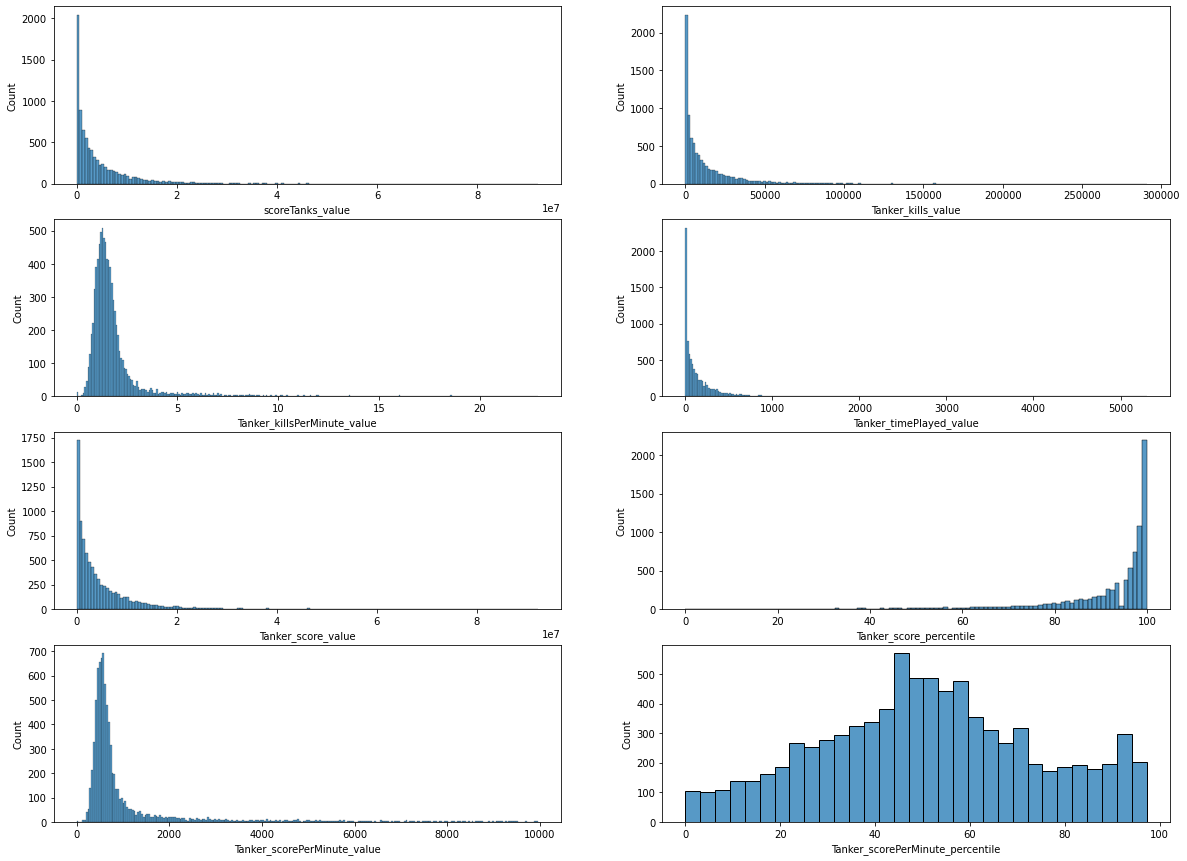

In [138]:
tank_features = [feature for feature in df.columns if 'tank' in feature.lower()]
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feature in zip(np.ravel(axes), tank_features):
    sns.histplot(data=df, x=feature, ax=ax)

# Missing Values

<AxesSubplot:>

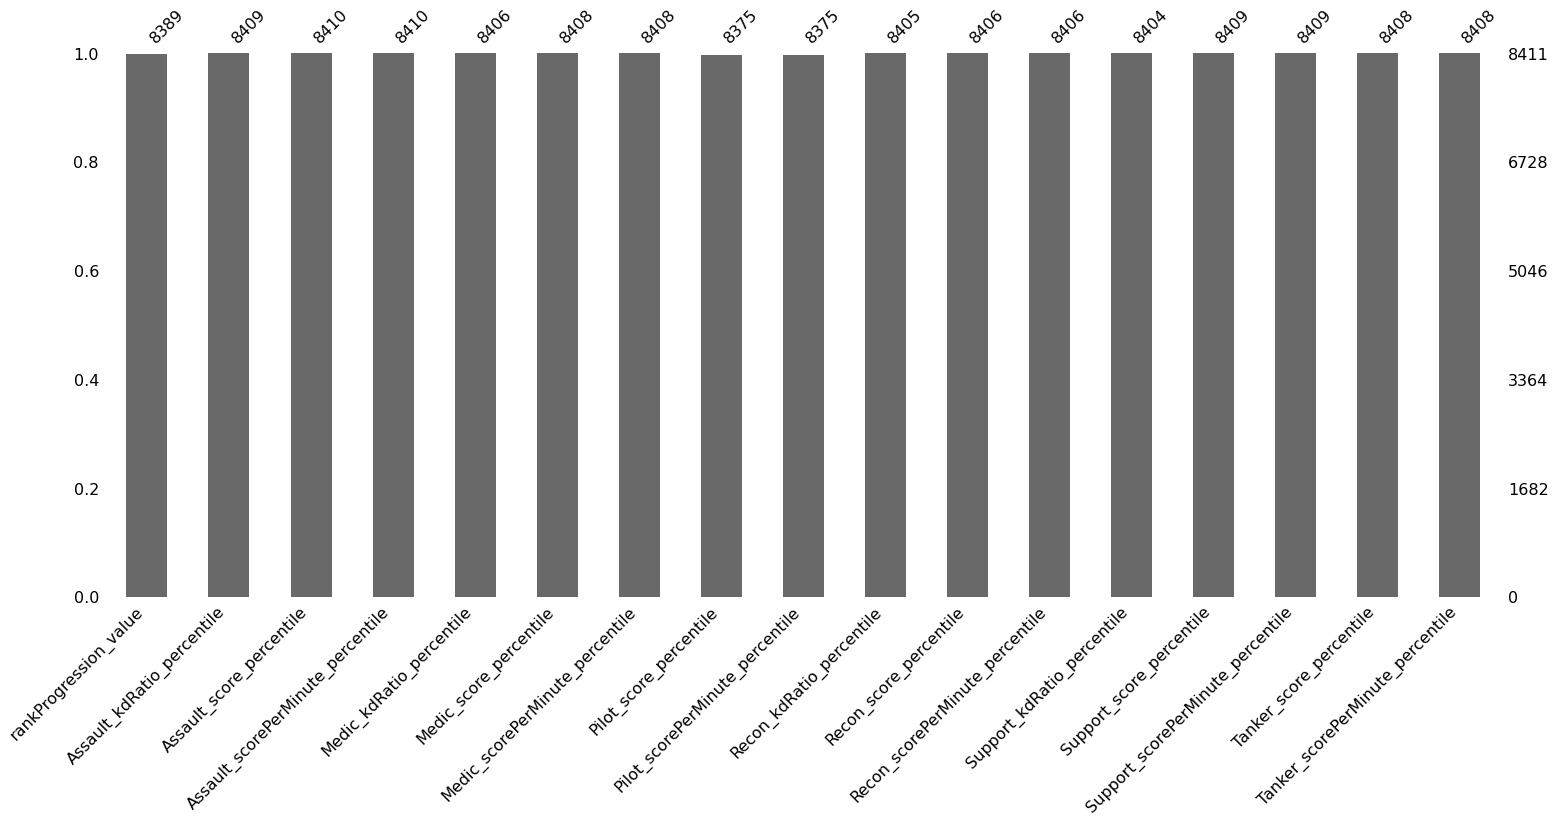

In [139]:
features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
missingno.bar(df[features_with_nan])

There are few enough features that I simply replace missing values with the mean value of the feature.

In [140]:
df_imputed = df
for feature in features_with_nan:
    df_imputed[feature] = df[feature].fillna(df[feature].mean())

In [141]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_imputed[df.columns[2:]])

pca = PCA()
pca_features = pca.fit_transform(df_scaled)

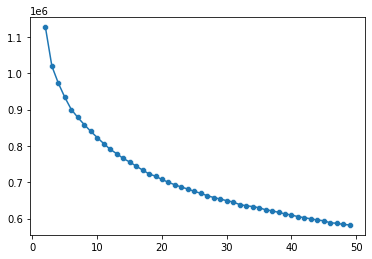

In [142]:
k_range = range(2, 50)
sse = []

for k in k_range:
    kmeans = KMeans(random_state=123, n_clusters=k)
    kmeans.fit(pca_features)
    sse.append(kmeans.inertia_)

sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)
plt.show()

<AxesSubplot:>

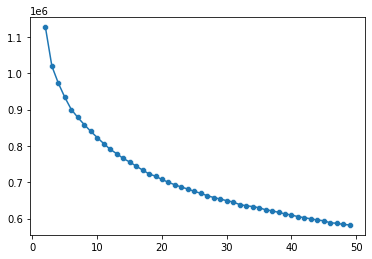

In [143]:
sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)

In [144]:
kmeans = KMeans(random_state=123, n_clusters=8)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [145]:
pcs = [f'pc_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=pcs)

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

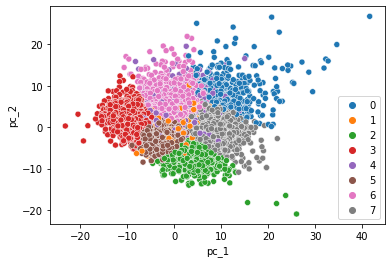

In [146]:

sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=clusters, palette='tab10')

In [147]:
df['clusters'] = kmeans.labels_
df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])
df_cluster_summary

C:\Users\Patrick\AppData\Local\Temp\ipykernel_18240\1938406920.py:2: FutureWarning: ['player_id', 'platform'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])


scorePerMinute_value             scorePerMinute_percentile  \
                         mean         std                      mean   
clusters                                                              
0                  506.555808  114.446385                 87.163441   
1                  424.956904   87.511100                 76.691963   
2                  526.297558  102.667388                 91.302391   
3                  254.184316   57.514994                 30.700607   
4                  448.201399   90.314633                 81.151701   
5                  405.647939   60.854553                 74.928724   
6                  352.062247   74.948156                 59.877090   
7                  554.617107   97.067913                 93.914210   

                    kdRatio_value           kdRatio_percentile             \
                std          mean       std               mean        std   
clusters                                                                    
0         15.155167      3.015020  1.316865          90.485753  10.222426   
1         18.970881      1.811741  0.613730          74.214065  17.619786   
2         10.290113      3.441122  1.283034          94.956884   4.146641   
3         16.714016      1.576709  1.121545          59.607013  25.803823   
4         15.786874      4.567078  3.316807          95.739626   4.673279   
5         14.359965      2.234576  0.811302          83.113778  12.797373   
6         21.185994      1.795040  0.743532          72.335831  19.792568   
7          7.118358      3.366008  1.207136          94.448544   4.844210   

            kills_value                ... scoreDefensive_value_PerMinute  \
                   mean           std  ...                           mean   
clusters                               ...                                  
0         314556.314516  93289.193033  ...                     120.937955   
1         109852.975270  37223.891904  ...                     131.076461   
2         116412.070899  27274.529042  ...                     123.698021   
3          60959.529332  21697.662636  ...                      56.438301   
4         175802.625850  62397.107744  ...                      85.590110   
5          90709.551607  23351.964146  ...                      98.690634   
6         141086.770901  40498.594623  ...                      88.010807   
7         198791.592233  43678.265869  ...                     130.341161   

                    scoreObjective_value_PerMinute             \
                std                           mean        std   
clusters                                                        
0         38.436575                     149.382707  63.183040   
1         41.507642                     137.119163  71.305856   
2         34.455545                     145.891994  59.953568   
3         24.512945                      91.289828  37.880887   
4         37.029220                     110.219843  41.069728   
5         29.442385                     130.578141  44.438407   
6         32.419002                     119.443068  47.968143   
7         36.096763                     166.412329  57.546809   

         scoreBonus_value_PerMinute            scoreSquad_value_PerMinute  \
                               mean        std                       mean   
clusters                                                                    
0                         82.720101  24.110424                  76.811214   
1                         65.786323  15.709204                  88.814979   
2                         88.287685  24.770077                  75.059812   
3                         45.384054  12.672373                  39.959226   
4                         70.489670  17.919672                  48.221400   
5                         63.867672  12.969897                  62.970941   
6                         55.891613  13.349370                  58.784713   
7                         89.136187  21.30411

In [148]:
df[df['player_id'] == 'psn/webwire']['timePlayed_value']

102    6172.341667
Name: timePlayed_value, dtype: float64

In [152]:
df_cluster_summary['kdRatio_value']['mean']

clusters
0    3.015020
1    1.811741
2    3.441122
3    1.576709
4    4.567078
5    2.234576
6    1.795040
7    3.366008
Name: mean, dtype: float64